# Bike Sharing Demand
This dataset consists of the number of public bikes rented in Seoul's bike sharing system at each hour. It also includes information about the weather and the time, such as whether it was a public holiday.

## Import modules and data

In [210]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [211]:
# Import data
file = 'data.csv'
df = pd.read_csv(file)

## Cleaning data and feature engineering

In [212]:
# Check data types 
df.dtypes

Date                         object
Rented Bike Count             int64
Hour                          int64
Temperature(C)              float64
Humidity(%)                   int64
Wind speed (m/s)            float64
Visibility (10m)              int64
Dew point temperature(C)    float64
Solar Radiation (MJ/m2)     float64
Rainfall(mm)                float64
Snowfall (cm)               float64
Seasons                      object
Holiday                      object
Functioning Day              object
dtype: object

In [213]:
# Convert date category to date time
df['Date'] = pd.to_datetime(df['Date'])

In [214]:
# Creating new column 'Week Day'
df['day_of_week'] = df['Date'].dt.day_name()

# Check unique values
df['day_of_week'].value_counts()

Sunday       1296
Wednesday    1272
Tuesday      1272
Thursday     1248
Saturday     1248
Friday       1224
Monday       1200
Name: day_of_week, dtype: int64

REASON CREATED: Day of the week can impact bike sharing demand. In particular, more people could rent bikes on the weekend because people could have more time (e.g. not working)

In [215]:
# Import ftod from funcs.py
from funcs import ftod

# Creating new 'time_of_day'
df['time_of_day'] = df.Hour.map(ftod) 

REASON CREATED: Time of day can impact bike sharing demand because more people will be awake to rent bikes. 

In [216]:
# Extracting month column 
df['month'] = pd.DatetimeIndex(df['Date']).month

REASON CREATED: The month can impact bike sharing demand because demand may fluctuate depending on the time of year.

In [217]:
# Count how many functioning and non-function days
df['Functioning Day'].value_counts()

Yes    8465
No      295
Name: Functioning Day, dtype: int64

In [218]:
# Examining the maximum rented bike count for non-functioning days
not_functioning = df['Functioning Day'] == "No"

print(f'The maximum value of a non-functioning day is {df[not_functioning]["Rented Bike Count"].max()}.')

The maximum value of a non-functioning day is 0.


Since the maximum value is 0, I decided to remove non-functioning days from the dataset because they are not adding any value, and these data points could affect model performance.

In [219]:
# Getting the rows that are functioning days
df = df[~not_functioning]

# Confirming that the non-functioning days were dropped
df['Functioning Day'].value_counts()

Yes    8465
Name: Functioning Day, dtype: int64

Since all of the data are function days, the 'Functioning Day' column becomes unneccessary. Thus, drop the the 'Functioning Day' column.

In [220]:
# Dropping 'Functioning Day' column
df.drop(columns=['Functioning Day'], axis=1, inplace=True)

# Reset index
df.reset_index()

# Confirming column was dropped
df.head()

Date  Rented Bike Count  Hour  Temperature(C)  Humidity(%)  \
0 2017-01-12                254     0            -5.2           37   
1 2017-01-12                204     1            -5.5           38   
2 2017-01-12                173     2            -6.0           39   
3 2017-01-12                107     3            -6.2           40   
4 2017-01-12                 78     4            -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(C)  \
0               2.2              2000                     -17.6   
1               0.8              2000                     -17.6   
2               1.0              2000                     -17.7   
3               0.9              2000                     -17.6   
4               2.3              2000                     -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  day_of_week time_of_day  month  
0    Thursday       night      1  
1    Thursday       night      1  
2    Thursday       night      1  
3    Thursday       night      1  
4    Thursday       night      1

In [221]:
# Converting 'Seasons', 'Holiday,' and 'day_of_week' to categorical
cat = ['Seasons', 'Holiday', 'day_of_week', 'month', 'Hour', 'time_of_day']

for c in cat:
    df[c] = df[c].astype('category')
    
# Verify change
df.dtypes

Date                        datetime64[ns]
Rented Bike Count                    int64
Hour                              category
Temperature(C)                     float64
Humidity(%)                          int64
Wind speed (m/s)                   float64
Visibility (10m)                     int64
Dew point temperature(C)           float64
Solar Radiation (MJ/m2)            float64
Rainfall(mm)                       float64
Snowfall (cm)                      float64
Seasons                           category
Holiday                           category
day_of_week                       category
time_of_day                       category
month                             category
dtype: object

In [222]:
# Dropping 'unneccesary columns'
cols = ['Solar Radiation (MJ/m2)', 'Dew point temperature(C)', 'Visibility (10m)', 'Snowfall (cm)', 'Date', 'Humidity(%)']
df.drop(cols, axis=1, inplace=True)
df.reset_index()

# Verify change
df.head()

Rented Bike Count Hour  Temperature(C)  Wind speed (m/s)  Rainfall(mm)  \
0                254    0            -5.2               2.2           0.0   
1                204    1            -5.5               0.8           0.0   
2                173    2            -6.0               1.0           0.0   
3                107    3            -6.2               0.9           0.0   
4                 78    4            -6.0               2.3           0.0   

  Seasons     Holiday day_of_week time_of_day month  
0  Winter  No Holiday    Thursday       night     1  
1  Winter  No Holiday    Thursday       night     1  
2  Winter  No Holiday    Thursday       night     1  
3  Winter  No Holiday    Thursday       night     1  
4  Winter  No Holiday    Thursday       night     1

## Exploratory Data Analysis

In [223]:
# Looking for correlations with 'Rented Bike Count'
corr_matrix = df.corr()
corr_matrix['Rented Bike Count'].sort_values(ascending=False)

Rented Bike Count    1.000000
Temperature(C)       0.562740
Wind speed (m/s)     0.125022
Rainfall(mm)        -0.128626
Name: Rented Bike Count, dtype: float64


Based on the correlation matrix, 'Temperature(C)' has the highest correlation with 'Rented Bike Count'. 

<AxesSubplot:xlabel='Temperature(C)', ylabel='Rented Bike Count'>

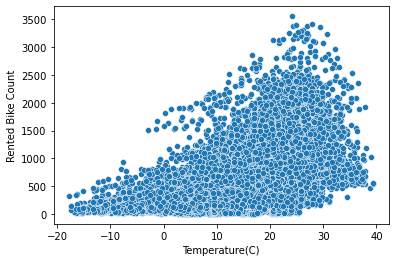

In [224]:
# Visualizing Temperature(C) and bike count
sns.scatterplot(x='Temperature(C)', y='Rented Bike Count', data=df)

'Temperature(C)' and 'Rented Bike Count' do not have a linear relationship. It seems that they have a nonlinear relationship because 'Rented Bike Count' increases as 'Temperature(C)' increases, but that linear trend disappears around 25°C (or 77°F) and 'Rented Bike Count' decreases.

<AxesSubplot:xlabel='Hour', ylabel='Rented Bike Count'>

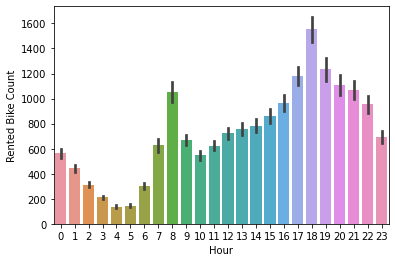

In [225]:
# Visualizing Hour and bike count
sns.barplot(x='Hour', y='Rented Bike Count', data=df)

The rented bike count is the highest at 6pm (18), 7pm (19), and 8am (8)

<AxesSubplot:xlabel='month', ylabel='Rented Bike Count'>

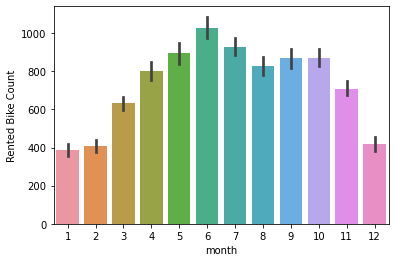

In [226]:
# Visualizing month and bike count
sns.barplot(x='month', y='Rented Bike Count', data=df)

The rented bike count is the lowest in January (1), February (2), and December (12). 

<AxesSubplot:xlabel='Seasons', ylabel='Rented Bike Count'>

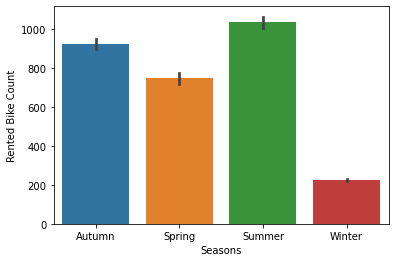

In [227]:
# Visualizing Seasons and bike count
sns.barplot(x='Seasons', y='Rented Bike Count', data=df)

Winter has a signficantly lower rented bike count compared to the other seasons. The temperature could be a possible explanation since winter tends to be colder. 

<AxesSubplot:xlabel='time_of_day', ylabel='Rented Bike Count'>

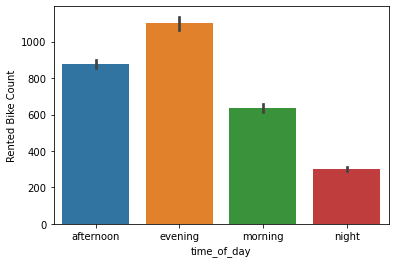

In [228]:
# Visualizing time_of_day and bike count
sns.barplot(x='time_of_day', y='Rented Bike Count', data=df)

During the night, the rented bike count is signficantly lower than the other times of the day. This could be due to less people being awake and the biking conditions. 

## Most important factors influencing bike demand

<ul>
    <li> Time of day </li>
    <li> Season </li>  
    <li> Temperature </li>
    <li> Month </li>
</ul>
   

## Note
I attempted to create a model that predicts bike count, but it was not successful. Regardless, here are the models I used. 

## Model selection

In [229]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Splitting data into training and test set 
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['month'])

# Making a copy of training set
df = train_set.drop('Rented Bike Count', axis=1)
df_labels = train_set['Rented Bike Count'].copy()

# Defining test set
X_test = test_set.drop('Rented Bike Count', axis=1)
y_test = test_set['Rented Bike Count'].copy()

In [230]:
# Import Pipeline, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Dealing with numerical features
cat_cols = ['Hour', 'Seasons', 'Holiday', 'day_of_week', 'month', 'time_of_day']

df_num = df.drop(cat_cols, axis=1)

num_pipeline = Pipeline([
    
            ('min_max_scaler', MinMaxScaler())
    
        ])

In [231]:
# Import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# Dealing with categorical features
df_cat = df[cat_cols]


cat_pipeline = Pipeline([
    
            ('one_hot', OneHotEncoder())
        
        ])

In [232]:
# Import ColumnTransformer
from sklearn.compose import ColumnTransformer

# Combine pipeline steps
num_attribs = list(df_num)
cat_attribs = cat_cols

full_pipeline = ColumnTransformer([
                
                ('num', num_pipeline, num_attribs),
                ('cat', cat_pipeline, cat_attribs),
    
            ])

# Fit and transform
df_prepared = full_pipeline.fit_transform(df)

### Linear Regression

In [233]:
# Import LinearRegression, mean_squared_error, and cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score

# Instantiate LinearRegression object: lin_reg 
lin_reg = LinearRegression()

# Fit and predict
lin_reg.fit(df_prepared, df_labels)
lin_predictions = lin_reg.predict(df_prepared)

# Calculate RMSE
rmse_lin = MSE(df_labels, lin_predictions)**(1/2)
rmse_lin

385.270271143674

### Ridge Regression

In [234]:
# Import Ridge
from sklearn.linear_model import Ridge

# Instantiate Ridge object
ridge = Ridge(alpha=0.5)

# Fit and predict
ridge.fit(df_prepared, df_labels)
ridge_predictions = ridge.predict(df_prepared)

# Calculate RMSE
rmse_ridge = MSE(df_labels, ridge_predictions)**(1/2)
rmse_ridge

385.3327729109214

### Lasso Regression

In [235]:
# Import Lasso
from sklearn.linear_model import Lasso

# Create lasso regression object
lasso = Lasso(alpha=0.5) # normalize ensures variables are on same scale

# fit and predict
lasso.fit(df_prepared, df_labels)
lasso_pred = lasso.predict(df_prepared)

# Calculate RMSE
rmse_lasso = MSE(df_labels, lasso_pred)**(1/2)
rmse_lasso

385.85059186131065

### Support Vector Regression

In [236]:
# Import SVR
from sklearn.svm import SVR

# Instantiate SVR object: svr
svr = SVR()

# Fit and predict
svr.fit(df_prepared, df_labels)
svr_pred = svr.predict(df_prepared)

# Calculate RMSE
rmse_svr = MSE(df_labels, svr_pred)**(1/2)
rmse_svr

599.8944678230573

### Decision Tree Regressor

In [237]:
# Import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# Set seed to 42 for reproducibility
SEED = 42

# Instantiate DecisionTreeRegressor object
tree_reg = DecisionTreeRegressor(random_state=SEED, max_depth=5, max_features=10, min_samples_leaf=10)

# Fit and predict
tree_reg.fit(df_prepared, df_labels)
tree_pred = tree_reg.predict(df_prepared)

# Calculate RMSE
rmse_tree = MSE(df_labels, tree_pred)**(1/2)
rmse_tree

446.98298922014055

### Random Forest Model

In [238]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate RandomForestRegressor object
forest_reg = RandomForestRegressor(max_features=10, n_estimators=35, random_state=SEED)

# Fit and predict
forest_reg.fit(df_prepared, df_labels)
forest_predictions = forest_reg.predict(df_prepared)

# Calculate RMSE
rmse_forest = MSE(df_labels, forest_predictions)**(1/2)
rmse_forest

95.28199404451243

### Gradient Boosting

In [239]:
# Import modules
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate a GradientBoostingRegressor object: gbr
gbr = GradientBoostingRegressor(n_estimators=300, max_depth=3, random_state=SEED)

# Fit and predict
gbr.fit(df_prepared, df_labels)
gbr_pred = gbr.predict(df_prepared)

# Calculate RMSE
gbr_rmse = MSE(df_labels, gbr_pred)**(1/2)
gbr_rmse

230.58903279266406

### AdaBoost Regressor

In [240]:
# Import AdaBoostRegressor
from sklearn.ensemble import AdaBoostRegressor

# Instantiate RandomForestRegressor and AdaBoostRegressor objects
rf = RandomForestRegressor(max_features=10, n_estimators=35, random_state=SEED)
adb = AdaBoostRegressor(base_estimator=rf, n_estimators=100)

# Fit and predict
adb.fit(df_prepared, df_labels)
adb_pred = adb.predict(df_prepared)

# Calculate RMSE
adb_rmse = MSE(df_labels, adb_pred)**(1/2)
adb_rmse

46.04615411641944

### Ensemble Learning

In [241]:
# Import VotingRegressor
from sklearn.ensemble import VotingRegressor

# Instantiate RandomForestRegressor and AdaBoostRegressor objects
rf = RandomForestRegressor(max_features=10, n_estimators=35, random_state=SEED)
adb = AdaBoostRegressor(base_estimator=rf, n_estimators=100)
gbr = GradientBoostingRegressor(n_estimators=300, max_depth=3, random_state=SEED)

# Define list of regressors
regressors = [('Random Forest', rf),
              ('AdaBoost', adb),
              ('Gradient Boosting', gbr)]

# Instantiate VotingRegressor
vr = VotingRegressor(estimators=regressors)

# Fit and predict
vr.fit(df_prepared, df_labels)
vr_pred = vr.predict(df_prepared)

# Calculate RMSE
vr_rmse = MSE(df_labels, vr_pred)**(1/2)
vr_rmse

112.11941727120237

### Model Selected
AdaBoost Regressor

### Hyperparameter Tuning

In [242]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'base_estimator__max_depth': np.arange(1,6), 
              'base_estimator__max_features': np.arange(10, 20),
              'base_estimator__min_samples_leaf': np.arange(1, 5),
              'base_estimator__n_estimators':np.arange(25, 50, 5)}

# Instantiate RandomForestRegressor and AdaBoostRegressor objects
rf = RandomForestRegressor(max_features=10, n_estimators=35, random_state=SEED)
adb = AdaBoostRegressor(base_estimator=rf, n_estimators=100) 

# Perform GridSearchCV
adb_cv = GridSearchCV(adb, param_grid, cv=5)

# Fit data
adb_cv.fit(df_prepared, df_labels)

# Print the tuned parameters and score
print("The best parameters for AdaBoost Regressor: {}".format(adb_cv.best_params_))

The best parameters for AdaBoost Regressor: {'base_estimator__max_depth': 5, 'base_estimator__max_features': 19, 'base_estimator__min_samples_leaf': 3, 'base_estimator__n_estimators': 25}


### Model Performance on Test Set

In [243]:
# Use Full Pipeline to convert X_test
rf = RandomForestRegressor(max_features=19, min_samples_leaf=2, n_estimators=20, max_depth=5)
final_model = AdaBoostRegressor(base_estimator=rf, n_estimators=20)

# Get X_test and y_test
X_test = test_set.drop('Rented Bike Count', axis=1)
y_test = test_set['Rented Bike Count'].copy()

# Use full_pipeline to transform X_test
X_test_prepared = full_pipeline.transform(X_test)

# Final predictions
final_model.fit(X_test_prepared, y_test)
final_predictions = final_model.predict(X_test_prepared)

# Calculate RMSE
RMSE = MSE(y_test, final_predictions)**(1/2)
RMSE

320.0920988880912

After trying numerous models, I was not able to create a model that can predict rented bike count accurately; I tried removing other columns and making the model less complicated, but it was still not successful. 